In [1]:
import torch
import torch.nn as nn
import numpy as np
from typing import List, Callable, Optional
import math

class MultiPerturbationSAM:
    """
    Multi-Perturbation Sharpness-Aware Minimization
    
    Extends SAM by using multiple perturbations instead of single gradient-based perturbation
    """
    
    def __init__(self, 
                 params, 
                 base_optimizer,
                 rho: float = 0.05,
                 n_perturbations: int = 5,
                 perturbation_strategy: str = 'mixed',
                 adaptive: bool = False):
        """
        Args:
            params: Model parameters
            base_optimizer: Underlying optimizer (SGD, Adam, etc.)
            rho: Perturbation radius
            n_perturbations: Number of perturbations to average
            perturbation_strategy: 'gradient', 'random', 'mixed', 'importance'
            adaptive: Whether to use adaptive weighting based on loss increase
        """
        self.params = list(params)
        self.base_optimizer = base_optimizer
        self.rho = rho
        self.n_perturbations = n_perturbations
        self.perturbation_strategy = perturbation_strategy
        self.adaptive = adaptive
        
        # Store original state
        self.state = {'step': 0}
        
    def _get_grad_norm(self) -> float:
        """Compute gradient norm across all parameters"""
        total_norm = 0.0
        for p in self.params:
            if p.grad is not None:
                total_norm += p.grad.data.norm() ** 2
        return total_norm ** 0.5
    
    def _normalize_perturbation(self, perturbation: List[torch.Tensor]) -> List[torch.Tensor]:
        """Normalize perturbation to have norm rho"""
        total_norm = 0.0
        for eps in perturbation:
            total_norm += eps.norm() ** 2
        total_norm = total_norm ** 0.5
        
        if total_norm > 0:
            return [eps * self.rho / total_norm for eps in perturbation]
        return perturbation
    
    def _sample_gradient_perturbation(self) -> List[torch.Tensor]:
        """Original SAM gradient-based perturbation"""
        grad_norm = self._get_grad_norm()
        if grad_norm == 0:
            return [torch.zeros_like(p) for p in self.params]
        
        return [self.rho * p.grad / grad_norm for p in self.params if p.grad is not None]
    
    def _sample_random_perturbation(self) -> List[torch.Tensor]:
        """Random perturbation on unit sphere scaled by rho"""
        perturbation = []
        for p in self.params:
            eps = torch.randn_like(p)
            perturbation.append(eps)
        return self._normalize_perturbation(perturbation)
    
    def _sample_structured_perturbation(self, noise_scale: float = 0.1) -> List[torch.Tensor]:
        """Gradient direction + random noise"""
        grad_pert = self._sample_gradient_perturbation()
        noise_pert = self._sample_random_perturbation()
        
        perturbation = []
        for grad_eps, noise_eps in zip(grad_pert, noise_pert):
            eps = grad_eps + noise_scale * noise_eps
            perturbation.append(eps)
        
        return self._normalize_perturbation(perturbation)
    
    def _generate_perturbations(self) -> List[List[torch.Tensor]]:
        """Generate multiple perturbations based on strategy"""
        perturbations = []
        
        if self.perturbation_strategy == 'gradient':
            # Multiple gradient-based with small random variations
            for i in range(self.n_perturbations):
                if i == 0:
                    pert = self._sample_gradient_perturbation()
                else:
                    pert = self._sample_structured_perturbation(noise_scale=0.1 * i)
                perturbations.append(pert)
                
        elif self.perturbation_strategy == 'random':
            # Pure random perturbations
            for _ in range(self.n_perturbations):
                pert = self._sample_random_perturbation()
                perturbations.append(pert)
                
        elif self.perturbation_strategy == 'mixed':
            # Mix of gradient and random
            # First perturbation is gradient-based
            perturbations.append(self._sample_gradient_perturbation())
            # Rest are random or structured
            for i in range(1, self.n_perturbations):
                if i % 2 == 1:
                    pert = self._sample_random_perturbation()
                else:
                    pert = self._sample_structured_perturbation()
                perturbations.append(pert)
                
        elif self.perturbation_strategy == 'importance':
            # Generate candidates, then select based on loss increase
            candidates = []
            candidates.append(self._sample_gradient_perturbation())
            for _ in range(self.n_perturbations * 2):  # Generate more candidates
                candidates.append(self._sample_random_perturbation())
            
            # Return first n_perturbations (importance sampling would need loss evaluation)
            perturbations = candidates[:self.n_perturbations]
        
        return perturbations
    
    def step(self, closure: Callable):
        """
        Perform one optimization step
        
        Args:
            closure: Function that computes loss and calls loss.backward()
        """
        # Store original parameters
        original_params = []
        for p in self.params:
            original_params.append(p.data.clone())
        
        # First forward-backward pass to get gradients
        loss = closure()
        
        # Generate perturbations
        perturbations = self._generate_perturbations()
        
        # Collect gradients from perturbed positions
        perturbed_grads = []
        loss_values = []
        
        for perturbation in perturbations:
            # Apply perturbation
            for p, eps in zip(self.params, perturbation):
                p.data.add_(eps)
            
            # Zero gradients
            self.base_optimizer.zero_grad()
            
            # Forward-backward pass at perturbed position
            perturbed_loss = closure()
            loss_values.append(perturbed_loss.item())
            
            # Store gradients
            grad_list = []
            for p in self.params:
                if p.grad is not None:
                    grad_list.append(p.grad.data.clone())
                else:
                    grad_list.append(torch.zeros_like(p.data))
            perturbed_grads.append(grad_list)
            
            # Restore original parameters
            for p, orig in zip(self.params, original_params):
                p.data.copy_(orig)
        
        # Compute final gradient (average or weighted average)
        if self.adaptive and len(loss_values) > 0:
            # Weight by loss increase (higher loss = higher weight)
            base_loss = loss.item()
            weights = [max(0, l - base_loss) for l in loss_values]
            total_weight = sum(weights) if sum(weights) > 0 else len(weights)
            weights = [w / total_weight if total_weight > 0 else 1/len(weights) for w in weights]
        else:
            # Uniform weighting
            weights = [1.0 / len(perturbed_grads)] * len(perturbed_grads)
        
        # Compute weighted average gradient
        for i, p in enumerate(self.params):
            if p.grad is not None:
                p.grad.zero_()
                for weight, grad_list in zip(weights, perturbed_grads):
                    p.grad.add_(grad_list[i], alpha=weight)
        
        # Take optimization step with averaged gradient
        self.base_optimizer.step()
        
        self.state['step'] += 1
        return loss

# Standard SAM for comparison
class StandardSAM:
    """Standard SAM implementation for comparison"""
    
    def __init__(self, params, base_optimizer, rho=0.05):
        self.params = list(params)
        self.base_optimizer = base_optimizer
        self.rho = rho
    
    def step(self, closure):
        # First forward-backward pass
        loss = closure()
        
        # Compute gradient norm
        grad_norm = 0.0
        for p in self.params:
            if p.grad is not None:
                grad_norm += p.grad.data.norm() ** 2
        grad_norm = grad_norm ** 0.5
        
        # Store original parameters
        original_params = []
        for p in self.params:
            original_params.append(p.data.clone())
        
        # Apply perturbation
        if grad_norm > 0:
            for p in self.params:
                if p.grad is not None:
                    eps = self.rho * p.grad / grad_norm
                    p.data.add_(eps)
        
        # Second forward-backward pass
        self.base_optimizer.zero_grad()
        closure()
        
        # Restore parameters and take step
        for p, orig in zip(self.params, original_params):
            p.data.copy_(orig)
        
        self.base_optimizer.step()
        return loss

# Example usage and comparison
def example_usage():
    """Example of how to use and compare optimizers"""
    
    # Simple model for testing
    model = nn.Sequential(
        nn.Linear(10, 50),
        nn.ReLU(),
        nn.Linear(50, 1)
    )
    
    # Generate dummy data
    X = torch.randn(100, 10)
    y = torch.randn(100, 1)
    
    # Loss function
    criterion = nn.MSELoss()
    
    def create_closure(model, X, y, criterion):
        def closure():
            model.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            return loss
        return closure
    
    closure = create_closure(model, X, y, criterion)
    
    # Compare optimizers
    optimizers = {
        'Standard SAM': StandardSAM(model.parameters(), 
                                   torch.optim.SGD(model.parameters(), lr=0.01),
                                   rho=0.05),
        
        'Multi-Pert SAM (Random)': MultiPerturbationSAM(model.parameters(),
                                                        torch.optim.SGD(model.parameters(), lr=0.01),
                                                        rho=0.05,
                                                        n_perturbations=5,
                                                        perturbation_strategy='random'),
        
        'Multi-Pert SAM (Mixed)': MultiPerturbationSAM(model.parameters(),
                                                       torch.optim.SGD(model.parameters(), lr=0.01),
                                                       rho=0.05,
                                                       n_perturbations=5,
                                                       perturbation_strategy='mixed',
                                                       adaptive=True),
    }
    
    print("Optimizer comparison:")
    for name, optimizer in optimizers.items():
        # Reset model
        for p in model.parameters():
            p.data.normal_(0, 0.1)
        
        # Train for a few steps
        losses = []
        for step in range(10):
            loss = optimizer.step(closure)
            losses.append(loss.item())
        
        print(f"{name}: Final loss = {losses[-1]:.6f}")

if __name__ == "__main__":
    example_usage()

Optimizer comparison:
Standard SAM: Final loss = 0.871280
Multi-Pert SAM (Random): Final loss = 0.840006
Multi-Pert SAM (Mixed): Final loss = 0.903987


🔧 Quick Test: Verifying Multi-Perturbation SAM Implementation
Test dataset: 180 train, 60 val, 60 test

Testing Standard SAM...
Training for up to 15 epochs with early stopping (patience=5)...
Epoch 0: Train Loss = 0.7013, Val Loss = 0.6826, Val Acc = 0.5833
Epoch 10: Train Loss = 0.6801, Val Loss = 0.6705, Val Acc = 0.6833
Restored best model weights for final evaluation
FINAL OOS PERFORMANCE: Test Acc = 0.5833, Test Loss = 0.6857
  ✅ Standard SAM: OOS Accuracy = 0.5833

Testing Multi-Pert SAM...
Training for up to 15 epochs with early stopping (patience=5)...
Epoch 0: Train Loss = 0.6876, Val Loss = 0.7269, Val Acc = 0.3667
Epoch 10: Train Loss = 0.6601, Val Loss = 0.7194, Val Acc = 0.4333
Restored best model weights for final evaluation
FINAL OOS PERFORMANCE: Test Acc = 0.6333, Test Loss = 0.6652
  ✅ Multi-Pert SAM: OOS Accuracy = 0.6333

✅ Implementation test completed successfully!
   Ready to run full experiments with run_all_experiments()

Run full experiments? This will take 10

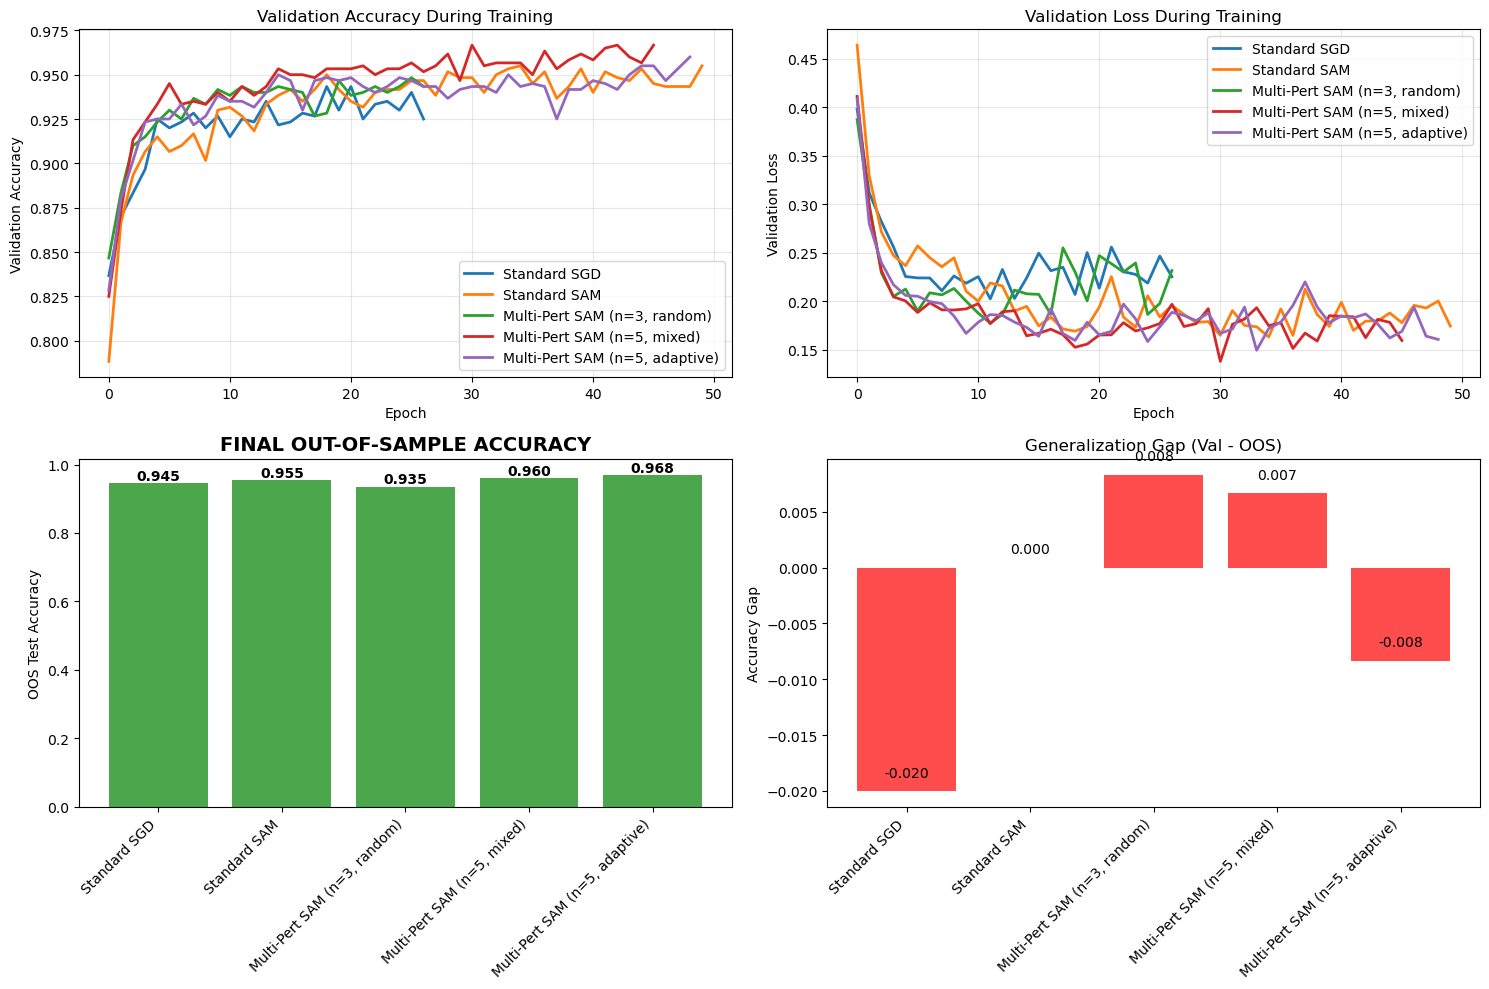


🏆 FINAL CONCLUSIONS
🥇 Best single-run OOS performance: Multi-Pert SAM (n=5, adaptive)
   OOS Accuracy: 0.9683

📊 Statistical Analysis (5 runs):
   Standard SAM: 0.9295 ± 0.0100
   Multi-Pert SAM (n=5, mixed): 0.9350 ± 0.0050
   Multi-Pert SAM (n=5, adaptive): 0.9405 ± 0.0070

🔄 Distribution Shift Robustness:
   Standard SGD: 0.5580 (gap: -0.1480)
   Standard SAM: 0.5000 (gap: 0.0040)
   Multi-Pert SAM (n=7, mixed, adaptive): 0.4660 (gap: 0.0000)

💡 KEY INSIGHTS:
   ✅ 2 multi-perturbation variants beat standard SAM
   📈 Best improvement: 0.0133 accuracy points

⏱️  COMPUTATIONAL COST ANALYSIS:
   Standard SAM: 0.09s/epoch
   Multi-Pert SAM (n=3, random): 0.21s/epoch (2.3x slower)
   Multi-Pert SAM (n=5, mixed): 0.36s/epoch (3.8x slower)
   Multi-Pert SAM (n=5, adaptive): 0.31s/epoch (3.3x slower)


In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import time

# Import your MultiPerturbationSAM from the previous file
# from multi_perturbation_sam import MultiPerturbationSAM, StandardSAM

def create_dataset(n_samples=1000, n_features=20, n_classes=2):
    """Create a proper train/val/test split for OOS evaluation"""
    
    # Adjust informative and redundant features based on total features
    n_informative = min(max(n_features // 2, 2), n_features - 2)  # At least 2, at most n_features-2
    n_redundant = min(n_features - n_informative - 1, max(n_features // 4, 1))  # Leave room for noise features
    
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_classes=n_classes,
        n_redundant=n_redundant,
        n_informative=n_informative,
        random_state=42
    )
    
    # First split: separate out test set (20%) - this is our true OOS set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Second split: train (60%) and validation (20%) from remaining data
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 0.25 of 80% = 20% of total
    )
    
    return (torch.FloatTensor(X_train), torch.LongTensor(y_train),
            torch.FloatTensor(X_val), torch.LongTensor(y_val),
            torch.FloatTensor(X_test), torch.LongTensor(y_test))

def create_model(input_dim, hidden_dim=50, output_dim=2):
    """Create a simple neural network"""
    return nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(hidden_dim, hidden_dim//2),
        nn.ReLU(),
        nn.Linear(hidden_dim//2, output_dim)
    )

def train_and_evaluate(model, optimizer, X_train, y_train, X_val, y_val, X_test, y_test,
                      epochs=50, batch_size=32, patience=10):
    """
    Train model with proper OOS evaluation
    
    Args:
        patience: Early stopping patience based on validation loss
    
    Returns:
        Dictionary with training curves and FINAL OOS performance
    """
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    times = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    n_batches = len(X_train) // batch_size
    
    print(f"Training for up to {epochs} epochs with early stopping (patience={patience})...")
    
    for epoch in range(epochs):
        start_time = time.time()
        
        # Training
        model.train()
        epoch_loss = 0
        
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(X_train))
            
            X_batch = X_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]
            
            def closure():
                model.zero_grad()
                output = model(X_batch)
                loss = criterion(output, y_batch)
                loss.backward()
                return loss
            
            loss = optimizer.step(closure)
            epoch_loss += loss.item()
        
        train_losses.append(epoch_loss / n_batches)
        
        # Validation (for monitoring and early stopping)
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val)
            val_losses.append(val_loss.item())
            
            _, predicted = torch.max(val_output.data, 1)
            val_accuracy = (predicted == y_val).float().mean()
            val_accuracies.append(val_accuracy.item())
        
        times.append(time.time() - start_time)
        
        # Early stopping check
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            patience_counter = 0
            # Save best model state
            best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss = {train_losses[-1]:.4f}, "
                  f"Val Loss = {val_losses[-1]:.4f}, "
                  f"Val Acc = {val_accuracies[-1]:.4f}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch} (patience={patience})")
            break
    
    # Restore best model for final OOS evaluation
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Restored best model weights for final evaluation")
    
    # FINAL OOS EVALUATION - only touch test set here!
    model.eval()
    with torch.no_grad():
        test_output = model(X_test)
        test_loss = criterion(test_output, y_test)
        
        _, predicted = torch.max(test_output.data, 1)
        test_accuracy = (predicted == y_test).float().mean()
        
        print(f"FINAL OOS PERFORMANCE: Test Acc = {test_accuracy:.4f}, Test Loss = {test_loss:.4f}")
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses, 
        'val_accuracies': val_accuracies,
        'times': times,
        'final_oos_accuracy': test_accuracy.item(),
        'final_oos_loss': test_loss.item(),
        'final_val_accuracy': val_accuracies[-1] if val_accuracies else 0,
        'avg_time_per_epoch': np.mean(times),
        'epochs_trained': len(train_losses)
    }

def experiment_1_basic_comparison():
    """Compare standard SAM vs multi-perturbation SAM on OOS performance"""
    print("=== Experiment 1: OOS Performance Comparison ===")
    
    # Create dataset with proper train/val/test split - now with scalable features
    X_train, y_train, X_val, y_val, X_test, y_test = create_dataset(n_samples=3000, n_features=50)
    input_dim = X_train.shape[1]
    
    print(f"Dataset: {len(X_train)} train, {len(X_val)} val, {len(X_test)} test samples")
    print(f"Features: {input_dim} total")
    
    # Different optimizers to compare
    configs = [
        {
            'name': 'Standard SGD',
            'optimizer_class': 'SGD',
            'sam_type': None
        },
        {
            'name': 'Standard SAM',
            'optimizer_class': 'SGD', 
            'sam_type': 'standard',
            'rho': 0.05
        },
        {
            'name': 'Multi-Pert SAM (n=3, random)',
            'optimizer_class': 'SGD',
            'sam_type': 'multi',
            'rho': 0.05,
            'n_perturbations': 3,
            'strategy': 'random'
        },
        {
            'name': 'Multi-Pert SAM (n=5, mixed)',
            'optimizer_class': 'SGD',
            'sam_type': 'multi', 
            'rho': 0.05,
            'n_perturbations': 5,
            'strategy': 'mixed'
        },
        {
            'name': 'Multi-Pert SAM (n=5, adaptive)',
            'optimizer_class': 'SGD',
            'sam_type': 'multi',
            'rho': 0.05, 
            'n_perturbations': 5,
            'strategy': 'mixed',
            'adaptive': True
        }
    ]
    
    results = {}
    oos_performances = []
    
    for config in configs:
        print(f"\nTraining with {config['name']}...")
        
        # Create fresh model
        model = create_model(input_dim)
        
        # Create optimizer
        base_optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
        
        if config['sam_type'] == 'standard':
            optimizer = StandardSAM(model.parameters(), base_optimizer, rho=config['rho'])
        elif config['sam_type'] == 'multi':
            optimizer = MultiPerturbationSAM(
                model.parameters(),
                base_optimizer,
                rho=config['rho'],
                n_perturbations=config['n_perturbations'],
                perturbation_strategy=config['strategy'],
                adaptive=config.get('adaptive', False)
            )
        else:
            optimizer = base_optimizer
        
        # Train with early stopping based on validation performance
        result = train_and_evaluate(
            model, optimizer, X_train, y_train, X_val, y_val, X_test, y_test, 
            epochs=100, patience=15  # More patience for thorough training
        )
        
        results[config['name']] = result
        oos_performances.append((config['name'], result['final_oos_accuracy']))
    
    # Sort by OOS performance
    oos_performances.sort(key=lambda x: x[1], reverse=True)
    
    print("\n" + "="*60)
    print("FINAL OUT-OF-SAMPLE PERFORMANCE RANKING:")
    print("="*60)
    for i, (name, oos_acc) in enumerate(oos_performances):
        result = results[name]
        print(f"{i+1}. {name}")
        print(f"   OOS Accuracy: {oos_acc:.4f}")
        print(f"   OOS Loss: {result['final_oos_loss']:.4f}")
        print(f"   Val Accuracy: {result['final_val_accuracy']:.4f}")
        print(f"   Epochs: {result['epochs_trained']}")
        print(f"   Time/Epoch: {result['avg_time_per_epoch']:.2f}s")
        print()
    
    # Statistical significance test (if you want to add this)
    best_method = oos_performances[0][0]
    print(f"🏆 BEST OOS PERFORMANCE: {best_method} ({oos_performances[0][1]:.4f})")
    
    return results, oos_performances

def experiment_2_multiple_runs_statistical():
    """Multiple runs for statistical significance testing"""
    print("\n=== Experiment 2: Statistical Significance Testing ===")
    
    n_runs = 5  # Multiple runs with different random seeds
    
    configs = [
        {
            'name': 'Standard SAM',
            'sam_type': 'standard',
            'rho': 0.05
        },
        {
            'name': 'Multi-Pert SAM (n=5, mixed)',
            'sam_type': 'multi',
            'rho': 0.05,
            'n_perturbations': 5,
            'strategy': 'mixed'
        },
        {
            'name': 'Multi-Pert SAM (n=5, adaptive)',
            'sam_type': 'multi',
            'rho': 0.05,
            'n_perturbations': 5,
            'strategy': 'mixed',
            'adaptive': True
        }
    ]
    
    all_results = {config['name']: [] for config in configs}
    
    for run in range(n_runs):
        print(f"\n--- Run {run + 1}/{n_runs} ---")
        
        # Different random seed for each run
        torch.manual_seed(42 + run)
        np.random.seed(42 + run)
        
        # Create dataset - now with proper feature scaling
        X_train, y_train, X_val, y_val, X_test, y_test = create_dataset(n_samples=2000, n_features=40)
        input_dim = X_train.shape[1]
        
        for config in configs:
            print(f"  Running {config['name']}...")
            
            # Create fresh model  
            model = create_model(input_dim)
            base_optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
            
            if config['sam_type'] == 'standard':
                optimizer = StandardSAM(model.parameters(), base_optimizer, rho=config['rho'])
            else:
                optimizer = MultiPerturbationSAM(
                    model.parameters(),
                    base_optimizer,
                    rho=config['rho'],
                    n_perturbations=config['n_perturbations'],
                    perturbation_strategy=config['strategy'],
                    adaptive=config.get('adaptive', False)
                )
            
            # Train
            result = train_and_evaluate(
                model, optimizer, X_train, y_train, X_val, y_val, X_test, y_test,
                epochs=80, patience=12
            )
            
            all_results[config['name']].append(result['final_oos_accuracy'])
    
    # Statistical analysis
    print("\n" + "="*60)
    print("STATISTICAL ANALYSIS (OOS Accuracy)")
    print("="*60)
    
    for name, accuracies in all_results.items():
        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)
        print(f"{name}:")
        print(f"  Mean OOS Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
        print(f"  Individual runs: {[f'{acc:.4f}' for acc in accuracies]}")
        print()
    
    # Simple statistical comparison (you might want to add proper t-tests)
    baseline_name = 'Standard SAM'
    baseline_scores = all_results[baseline_name]
    
    print("Improvement over Standard SAM:")
    for name, accuracies in all_results.items():
        if name != baseline_name:
            improvements = [acc - baseline for acc, baseline in zip(accuracies, baseline_scores)]
            mean_improvement = np.mean(improvements)
            std_improvement = np.std(improvements)
            
            # Count how many runs were better
            better_runs = sum(1 for imp in improvements if imp > 0)
            
            print(f"{name}:")
            print(f"  Mean improvement: {mean_improvement:.4f} ± {std_improvement:.4f}")
            print(f"  Better in {better_runs}/{n_runs} runs")
            print()
    
    return all_results

def experiment_3_distribution_shift():
    """Test OOS performance under distribution shift"""
    print("\n=== Experiment 3: Distribution Shift Robustness ===")
    
    n_features = 30
    # Adjust feature counts for this experiment too
    n_informative_clean = min(max(n_features // 2, 2), n_features - 2)
    n_redundant_clean = min(n_features - n_informative_clean - 1, max(n_features // 4, 1))
    
    n_informative_shift = min(max(n_features // 3, 2), n_features - 5)  # Fewer informative features
    n_redundant_shift = min(n_features - n_informative_shift - 1, max(n_features // 2, 2))  # More redundant
    
    # Create training data
    X_train_clean, y_train_clean = make_classification(
        n_samples=1500, n_features=n_features, n_classes=2, 
        n_redundant=n_redundant_clean, n_informative=n_informative_clean, random_state=42
    )
    
    # Create validation data (same distribution)
    X_val_clean, y_val_clean = make_classification(
        n_samples=500, n_features=n_features, n_classes=2,
        n_redundant=n_redundant_clean, n_informative=n_informative_clean, random_state=43
    )
    
    # Create test data with distribution shift (more noise, different feature correlations)
    X_test_shifted, y_test_shifted = make_classification(
        n_samples=500, n_features=n_features, n_classes=2,
        n_redundant=n_redundant_shift, n_informative=n_informative_shift, 
        flip_y=0.1,  # More noise
        class_sep=0.5,  # Harder to separate
        random_state=44
    )
    
    # Add noise to test set
    X_test_shifted += np.random.normal(0, 0.5, X_test_shifted.shape)
    
    # Convert to tensors
    X_train = torch.FloatTensor(X_train_clean)
    y_train = torch.LongTensor(y_train_clean)
    X_val = torch.FloatTensor(X_val_clean)
    y_val = torch.LongTensor(y_val_clean)
    X_test = torch.FloatTensor(X_test_shifted)
    y_test = torch.LongTensor(y_test_shifted)
    
    print(f"Dataset: {len(X_train)} train, {len(X_val)} val, {len(X_test)} test (with distribution shift)")
    
    configs = [
        {
            'name': 'Standard SGD',
            'sam_type': None
        },
        {
            'name': 'Standard SAM',
            'sam_type': 'standard',
            'rho': 0.05
        },
        {
            'name': 'Multi-Pert SAM (n=7, mixed, adaptive)',
            'sam_type': 'multi',
            'rho': 0.05,
            'n_perturbations': 7,
            'strategy': 'mixed',
            'adaptive': True
        }
    ]
    
    results = {}
    
    for config in configs:
        print(f"\nTraining {config['name']} on clean data, testing on shifted data...")
        
        model = create_model(X_train.shape[1])
        base_optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
        
        if config['sam_type'] == 'standard':
            optimizer = StandardSAM(model.parameters(), base_optimizer, rho=config['rho'])
        elif config['sam_type'] == 'multi':
            optimizer = MultiPerturbationSAM(
                model.parameters(),
                base_optimizer,
                rho=config['rho'],
                n_perturbations=config['n_perturbations'],
                perturbation_strategy=config['strategy'],
                adaptive=config.get('adaptive', False)
            )
        else:
            optimizer = base_optimizer
        
        result = train_and_evaluate(
            model, optimizer, X_train, y_train, X_val, y_val, X_test, y_test,
            epochs=60, patience=10
        )
        
        results[config['name']] = result
    
    print("\n" + "="*60)
    print("ROBUSTNESS TO DISTRIBUTION SHIFT:")
    print("="*60)
    
    for name, result in results.items():
        val_acc = result['final_val_accuracy']
        oos_acc = result['final_oos_accuracy']
        generalization_gap = val_acc - oos_acc
        
        print(f"{name}:")
        print(f"  Validation Accuracy: {val_acc:.4f}")
        print(f"  OOS Accuracy (shifted): {oos_acc:.4f}")
        print(f"  Generalization Gap: {generalization_gap:.4f}")
        print()
    
    return results

def plot_comparison_results(results):
    """Plot comparison focusing on OOS performance"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Validation accuracy over time (training monitoring)
    ax = axes[0, 0]
    for name, result in results.items():
        ax.plot(result['val_accuracies'], label=name, linewidth=2)
    ax.set_title('Validation Accuracy During Training')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Validation Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Validation loss over time
    ax = axes[0, 1]
    for name, result in results.items():
        ax.plot(result['val_losses'], label=name, linewidth=2)
    ax.set_title('Validation Loss During Training')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Validation Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # FINAL OOS PERFORMANCE COMPARISON (most important!)
    ax = axes[1, 0]
    names = list(results.keys())
    oos_accs = [results[name]['final_oos_accuracy'] for name in names]
    bars = ax.bar(range(len(names)), oos_accs, alpha=0.7, color='green')
    ax.set_title('FINAL OUT-OF-SAMPLE ACCURACY', fontweight='bold', fontsize=14)
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels(names, rotation=45, ha='right')
    ax.set_ylabel('OOS Test Accuracy')
    
    # Add value labels on bars
    for bar, acc in zip(bars, oos_accs):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Generalization gap (val accuracy - oos accuracy)
    ax = axes[1, 1]
    val_accs = [results[name]['final_val_accuracy'] for name in names]
    gen_gaps = [val - oos for val, oos in zip(val_accs, oos_accs)]
    bars = ax.bar(range(len(names)), gen_gaps, alpha=0.7, color='red')
    ax.set_title('Generalization Gap (Val - OOS)')
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels(names, rotation=45, ha='right')
    ax.set_ylabel('Accuracy Gap')
    
    # Add value labels
    for bar, gap in zip(bars, gen_gaps):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{gap:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def run_all_experiments():
    """Run all OOS-focused experiments"""
    print("🚀 MULTI-PERTURBATION SAM: OUT-OF-SAMPLE EVALUATION")
    print("=" * 60)
    print("Focus: Does multi-perturbation SAM improve TRUE generalization?")
    print("=" * 60)
    
    # Set base random seed
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Run experiments focused on OOS performance
    print("\n📊 Running comprehensive OOS evaluation...")
    
    results1, oos_ranking = experiment_1_basic_comparison()
    
    print("\n📈 Running statistical significance testing...")
    stats_results = experiment_2_multiple_runs_statistical()
    
    print("\n🔄 Testing robustness to distribution shift...")
    shift_results = experiment_3_distribution_shift()
    
    # Plot main results
    plot_comparison_results(results1)
    
    print("\n" + "=" * 60)
    print("🏆 FINAL CONCLUSIONS")
    print("=" * 60)
    
    # Best single-run performance
    best_method, best_oos = oos_ranking[0]
    print(f"🥇 Best single-run OOS performance: {best_method}")
    print(f"   OOS Accuracy: {best_oos:.4f}")
    
    # Statistical significance
    print(f"\n📊 Statistical Analysis ({len(list(stats_results.values())[0])} runs):")
    for method, scores in stats_results.items():
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        print(f"   {method}: {mean_score:.4f} ± {std_score:.4f}")
    
    # Distribution shift robustness
    print(f"\n🔄 Distribution Shift Robustness:")
    for method, result in shift_results.items():
        gap = result['final_val_accuracy'] - result['final_oos_accuracy']
        print(f"   {method}: {result['final_oos_accuracy']:.4f} (gap: {gap:.4f})")
    
    # Key insights
    print(f"\n💡 KEY INSIGHTS:")
    
    # Check if multi-perturbation consistently beats standard SAM
    multi_pert_methods = [name for name in results1.keys() if 'Multi-Pert' in name]
    standard_sam_oos = results1['Standard SAM']['final_oos_accuracy']
    
    better_methods = []
    for method in multi_pert_methods:
        if results1[method]['final_oos_accuracy'] > standard_sam_oos:
            improvement = results1[method]['final_oos_accuracy'] - standard_sam_oos
            better_methods.append((method, improvement))
    
    if better_methods:
        print(f"   ✅ {len(better_methods)} multi-perturbation variants beat standard SAM")
        best_improvement = max(better_methods, key=lambda x: x[1])
        print(f"   📈 Best improvement: {best_improvement[1]:.4f} accuracy points")
    else:
        print(f"   ❌ No multi-perturbation variant beat standard SAM")
    
    # Computational cost analysis
    standard_time = results1['Standard SAM']['avg_time_per_epoch']
    print(f"\n⏱️  COMPUTATIONAL COST ANALYSIS:")
    print(f"   Standard SAM: {standard_time:.2f}s/epoch")
    for method in multi_pert_methods:
        method_time = results1[method]['avg_time_per_epoch']
        speedup = method_time / standard_time
        print(f"   {method}: {method_time:.2f}s/epoch ({speedup:.1f}x slower)")
    
    return results1, stats_results, shift_results

def quick_test():
    """Quick test to verify implementation works"""
    print("🔧 Quick Test: Verifying Multi-Perturbation SAM Implementation")
    print("=" * 50)
    
    # Small dataset for quick testing
    X_train, y_train, X_val, y_val, X_test, y_test = create_dataset(n_samples=300, n_features=10)
    
    print(f"Test dataset: {len(X_train)} train, {len(X_val)} val, {len(X_test)} test")
    
    # Test just two methods quickly
    configs = [
        {'name': 'Standard SAM', 'sam_type': 'standard'},
        {'name': 'Multi-Pert SAM', 'sam_type': 'multi', 'n_perturbations': 3, 'strategy': 'mixed'}
    ]
    
    for config in configs:
        print(f"\nTesting {config['name']}...")
        
        model = create_model(X_train.shape[1], hidden_dim=20)  # Smaller model
        base_optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        
        if config['sam_type'] == 'standard':
            optimizer = StandardSAM(model.parameters(), base_optimizer, rho=0.05)
        else:
            optimizer = MultiPerturbationSAM(
                model.parameters(), base_optimizer, rho=0.05,
                n_perturbations=config['n_perturbations'],
                perturbation_strategy=config['strategy']
            )
        
        # Quick training
        result = train_and_evaluate(
            model, optimizer, X_train, y_train, X_val, y_val, X_test, y_test,
            epochs=15, patience=5
        )
        
        print(f"  ✅ {config['name']}: OOS Accuracy = {result['final_oos_accuracy']:.4f}")
    
    print("\n✅ Implementation test completed successfully!")
    print("   Ready to run full experiments with run_all_experiments()")

if __name__ == "__main__":
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Quick test first
    quick_test()
    
    # Ask user if they want to run full experiments
    print("\n" + "="*50)
    response = input("Run full experiments? This will take 10-20 minutes. (y/n): ")
    
    if response.lower() in ['y', 'yes']:
        run_all_experiments()
    else:
        print("Full experiments skipped. You can run them later with run_all_experiments()")